In [57]:
import pandas as pd
import seaborn as sns
import numpy as np
from statannotations.Annotator import Annotator
from scipy.stats import normaltest
import scipy.stats as stats
from matplotlib import pyplot as plt
import pingouin as pg


sns.set(rc={'figure.figsize':(25,10)})

In [58]:
our_color_palette ={"WT": "#F2C14E", "KO": "#F15BB5", "OE": "#368F8B"}
genotype_dict = {"dicer_KO": "KO", "dicer_overexpressed": "OE", "wild_type": "WT", "dicer_ko": "KO", "dicer_over_expressing": "OE"}
passage_dict = {"passage_1": "P1", "passage_5": "P5", "passage_10": "P10"}
our_color_palette ={"WT": "#F2C14E", "KO": "#F15BB5", "OE": "#368F8B"}

genotype_order = ["WT", "KO", "OE"]
passage_order = ['P1','P5','P10']

### plot nucleotide diversity across genome, for coding and non-coding regions

Values were computed with SNPGenie (https://github.com/chasewnelson/SNPGenie). 

In [77]:
df_WT= pd.read_csv('../../resources/run_workflow/results_cluster/wild_type/snpgenie_site_results.csv')
df_KO = pd.read_csv('../../resources/run_workflow/results_cluster/dicer_KO/snpgenie_site_results.csv')
df_OE = pd.read_csv('../../resources/run_workflow/results_cluster/dicer_overexpression/snpgenie_site_results.csv')

df_pi = pd.concat([df_WT, df_KO, df_OE])[['site', 'pi', 'genotype', 'replicate', 'passage']]

df_pi["genotype"] = df_pi["genotype"].apply(lambda x: genotype_dict[x])
df_pi["passage"] = df_pi["passage"].apply(lambda x: passage_dict[x])


In [92]:
# total number of sites: 9264

In [98]:
# coding position taken from:
# resources/references/dcv_eb_ref_annotation_genomic.gbff

n_sites_reference = 9264
coding_positions = list(range(799, 6078)) +  list(range(6267, 8972))
n_coding_sites = len(coding_positions)
n_noncoding_sites = n_sites_reference - n_coding_sites

df_pi['coding'] = df_pi['site'].isin(coding_positions)

In [108]:
df_pi_coding = pd.pivot_table(data=df_pi[df_pi['coding']==True],
                              values='pi', 
                              index=['genotype', 'replicate', 'passage'], 
                              aggfunc='sum').reset_index()
df_pi_coding['pi'] = df_pi_coding['pi']/n_coding_sites
df_pi_coding['measure'] = 'coding'


df_pi_noncoding = pd.pivot_table(data=df_pi[df_pi['coding']==False],
                              values='pi', 
                              index=['genotype', 'replicate', 'passage'], 
                              aggfunc='sum').reset_index()
df_pi_noncoding['pi'] = df_pi_noncoding['pi']/n_noncoding_sites
df_pi_noncoding['measure'] = 'noncoding'

df_pi_fullgenome = pd.pivot_table(data=df_pi,
                              values='pi', 
                              index=['genotype', 'replicate', 'passage'], 
                              aggfunc='sum').reset_index()
df_pi_fullgenome['pi'] = df_pi_fullgenome['pi']/n_sites_reference
df_pi_fullgenome['measure'] = 'fullgenome'


df_pi_res = pd.concat([df_pi_coding, df_pi_noncoding, df_pi_fullgenome])

In [109]:
df_pi_res

,genotype,replicate,passage,pi,measure
0,KO,replicate_a,P1,0.000229,coding
1,KO,replicate_a,P10,0.000312,coding
2,KO,replicate_a,P5,0.000103,coding
3,KO,replicate_b,P1,0.000248,coding
4,KO,replicate_b,P10,0.000248,coding
...,...,...,...,...,...
40,WT,replicate_d,P10,0.000253,fullgenome
41,WT,replicate_d,P5,0.000307,fullgenome
42,WT,replicate_e,P1,0.000276,fullgenome
43,WT,replicate_e,P10,0.000399,fullgenome


In [119]:
print(normaltest(df_pi_res[df_pi_res['measure']=="fullgenome"]['pi']).pvalue)

0.4323681594228982


In [120]:
# test normalitiy --> H0: samples comes from normal distribution
print(normaltest(np.log(df_pi_res[df_pi_res['measure']=="coding"]['pi'])).pvalue)

0.172319179344947


In [121]:
# test normalitiy --> H0: samples comes from normal distribution
print(normaltest(df_pi_res[df_pi_res['measure']=="noncoding"]['pi']).pvalue)

1.2355141632266185e-10


Text(0.5, 1.0, 'Full genome')

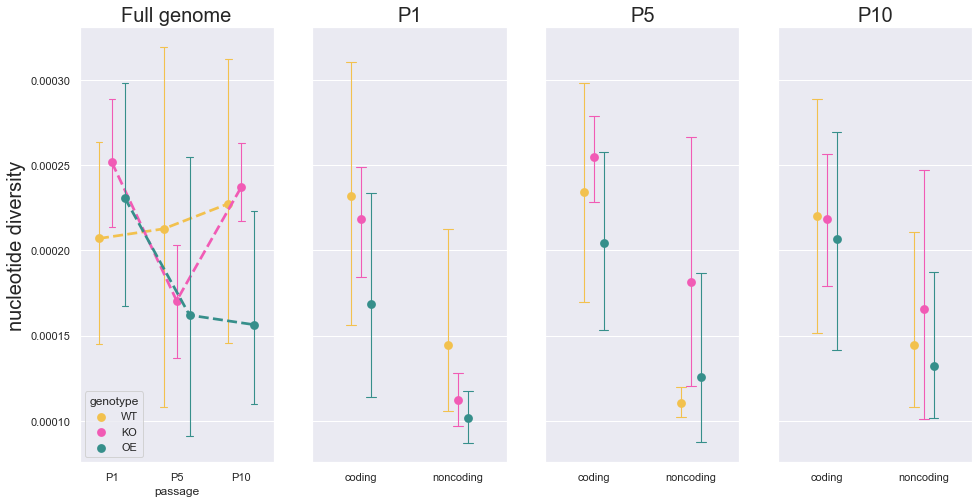

In [124]:
fig, ax = plt.subplots(1,4,  sharey=True, figsize=(16,8))

sns.pointplot(
        ax=ax[0],
        data=df_pi_res[df_pi_res['measure']=="fullgenome"], 
        markers='o', 
        linestyles='--',
        x="passage", 
        y='pi', 
        hue ='genotype', 
        errorbar="se",
        hue_order=genotype_order, 
        errwidth=1.1, 
        capsize=0.1,
        palette=our_color_palette,
        order=passage_order, 
        dodge=0.4,
    )

for idx, passage in enumerate(passage_order): 
    sns.pointplot(
        ax= ax[idx+1],
        data=df_pi_res[(df_pi_res['measure']!="fullgenome") & (df_pi_res['passage']!=passage)], 
        kind='point', 
        markers='o', 
        linestyles='',
        x="measure", 
        y='pi', 
        hue ='genotype',
        errorbar="se",
        hue_order=genotype_order, 
        errwidth=1.1, 
        capsize=0.1,
        palette=our_color_palette,
        dodge=0.2,
    )
    ax[idx+1].set_title(passage, fontsize=20)
    ax[idx+1].set_ylabel("")
    ax[idx+1].set_xlabel("")
    ax[idx+1].get_legend().remove()
    
ax[0].set_ylabel("nucleotide diversity", fontsize=20)
ax[0].set_title("Full genome", fontsize=20)


In [125]:
fig.savefig("./000__Manuscript_figures/Supplement_Figure_3A_nucleotide_diversity.pdf")
fig.savefig("./000__Manuscript_figures/Supplement_Figure_3A_nucleotide_diversity.svg")

### mixed ANOVA for nulceotide diversity (full genome)

<AxesSubplot: xlabel='passage', ylabel='pi'>

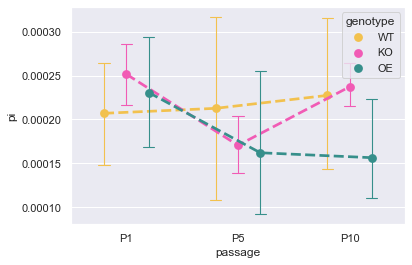

In [126]:
sns.pointplot(
        data=df_pi_res[df_pi_res['measure']=="fullgenome"], 
        markers='o', 
        linestyles='--',
        x="passage", 
        y='pi', 
        hue ='genotype', 
        errorbar="se",
        hue_order=genotype_order, 
        errwidth=1.1, 
        capsize=0.1,
        palette=our_color_palette,
        order=passage_order, 
        dodge=0.4,
    )

In [127]:
df_pi_res['id'] = df_pi_res['genotype'] + df_pi_res['replicate']

res = pg.mixed_anova(dv='pi', 
                  within='passage', 
                  between='genotype',
                  subject='id', 
                  data=df_pi_res[(df_pi_res['measure']=="fullgenome")], 
                 )

res

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,genotype,1.214901e-08,2,12,6.074506e-09,0.599249,0.564859,0.090806,NaN
1,passage,1.730925e-08,2,24,8.654625e-09,1.436023,0.257588,0.106879,0.757424
2,Interaction,1.961274e-08,4,24,4.903185e-09,0.813563,0.528978,0.119403,NaN


###  compare nulceotide diversity between coding and noncoding

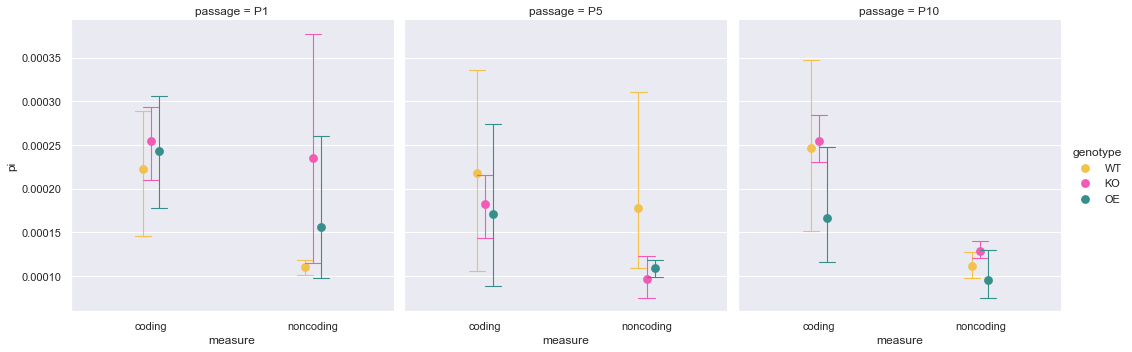

In [128]:

sns.catplot(
        data=df_pi_res[df_pi_res['measure']!="fullgenome"], 
        kind='point', 
        markers='o', 
        linestyles='',
        x="measure", 
        y='pi', 
        hue ='genotype',
        col='passage',
        errorbar="se",
        hue_order=genotype_order, 
        errwidth=1.1, 
        capsize=0.1,
        palette=our_color_palette,
        col_order=passage_order, 
        dodge=0.1,
    )

In [129]:
df_pop_long_mean = df_pi_res[(df_pi_res['measure']!="fullgenome")].pivot_table(values='pi', 
                                           index=['measure', 'genotype', 'passage'],
                                           aggfunc='mean').reset_index()

df_pop_long_mean['id'] = df_pop_long_mean['genotype'] + df_pop_long_mean['measure']

In [130]:

res = pg.mixed_anova(dv='pi', 
                     within='passage', 
                     between='measure',
                     subject='id', 
                     data=df_pop_long_mean, 
                 )

res

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,measure,3.036093e-08,1,4,3.036093e-08,28.017623,0.006115,0.875069,NaN
1,passage,6.719174e-09,2,8,3.359587e-09,1.856742,0.217578,0.317026,0.802816
2,Interaction,1.943572e-09,2,8,9.717859e-10,0.537077,0.604137,0.118375,NaN
